In [1]:
cwk_dir ="drive/MyDrive/NLU Coursework/" #For running in Jack's Google Drive

# Setup

## Connect Google Drive Folder

In [2]:
from google.colab import drive
import os
import sys
drive.mount('/content/drive/')

Mounted at /content/drive/


## Imports

In [93]:
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Add, Layer, LSTM, Bidirectional, Embedding, concatenate, BatchNormalization, SimpleRNN, Attention, GlobalMaxPooling1D, GlobalAveragePooling1D, Conv1D, MaxPooling1D, TimeDistributed, subtract, multiply
from tensorflow.keras.optimizers.legacy import SGD, Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import SparseCategoricalAccuracy as Acc
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy as KAcc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2

import keras
from keras.utils import to_categorical

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import typing
from PIL import Image
import json
from nltk.corpus import stopwords
import gensim.downloader as api
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
import string
from random import randint
from itertools import chain
import spacy

In [95]:
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel

In [96]:
#Imports from local libraries
sys.path.append(cwk_dir)
from classes.evaluation import evaluate
from classes.preprocessing import load_data

In [97]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Primary Variables

Filepath variables

In [ ]:
solution_dir = os.path.join(cwk_dir, "solution_B")
models_dir = os.path.join(solution_dir, "models")
results_dir = os.path.join(solution_dir, "results")

Preprocessing variables

In [ ]:
LOWER: bool = True
PADDING: str = "post"

# nltk.download('stopwords')
# STOP_WORDS = set(stopwords.words('english'))
STOP_WORDS = []

Training variables

In [ ]:
# INITIAL_LR: float = 2e-5
INITIAL_LR: float = 0.001

EPOCHS: int = 20
VALIDATION_SPLIT: float = 0.2
BATCH_SIZE: int = 256
DROPOUT: float = 0.3

LOSS_FUNCTION: str = "categorical_crossentropy"
OUTPUT_ACTIVATION: str = "softmax"
NUM_LABELS: int = 2

OPTIMIZER = RMSprop(INITIAL_LR)

Other

In [ ]:
MAX_PREMISE_LENGTH: int = None
MAX_HYPOTHESIS_LENGTH: int = None

VOCAB_SIZE: int = None #None is the value to denote that there is no vocab size yet. This is set later, once we have the training data
EMBEDDING_SIZE: int = None

## Functions

In [12]:
NLP = spacy.load("en_core_web_sm")

def get_ner_tags(sentences: typing.List[str]) -> typing.List[str]:
  """
  Returns a list of the NER tags for a list of sentences
  """
  sentences = list(NLP.pipe(sentences))
  return [[token.ent_type_ for token in sentence] for sentence in sentences]

In [13]:
def pad_lists(lists, value, length: int):
  """
  Pads the lists with the value specified & returns this
  """
  return [(next + length * [value])[:length] for next in lists]

In [14]:
def average_sequence_length(sequence: typing.List[str]) -> int:
  """
  Takes a list of sentences & returns the average length of sentences in that sequence
  """
  lengths = [len(sample) for sample in sequence]
  return int(np.sum(lengths)/len(lengths)) + 1

In [15]:
def show_model_architecture(model: Model, filename: str) -> None:
  """
  Takes a model architecture and will a diagram of the architecture. Saves this diagram also, to the filename specified
  """
  model.summary()
  filename = os.path.join(results_dir, filename)
  plot_model(model, to_file=filename)
  img = Image.open(filename)
  fig, ax = plt.subplots(figsize=(15, 15))
  plt.imshow(img, aspect='equal')

In [16]:
def tokenize_data(tokenizer: BertTokenizer, premises: typing.List[str], hypotheses: typing.List[str]) ->typing.Tuple[np.array, np.array]:
  """
  Uses the input tokenizer to tokenizer the premises & hypotheses. Will then pad the sequences correctly, using the maxlen passed in
  """
  premises = [tokenizer.encode(premise, add_special_tokens=True) for premise in premises]
  hypotheses = [tokenizer.encode(hypothesis, add_special_tokens=True) for hypothesis in hypotheses]

  premises = pad_sequences(premises, maxlen=MAX_PREMISE_LENGTH, padding=PADDING, value=0)
  hypotheses = pad_sequences(hypotheses, maxlen=MAX_HYPOTHESIS_LENGTH, padding=PADDING, value=0)

  return (np.array(premises), np.array(hypotheses))

In [17]:
def save_keras_model(model: Model, filename: str) -> None:
  """
  Saves the model that's been made
  """
  model.save_weights(os.path.join(models_dir, f"{filename}.hdf5"))
  model_architecture = model.to_json()
  with open(os.path.join(models_dir, f"{filename}.json"), "w") as f:
    f.write(json.dumps(model_architecture, indent=4))

In [18]:
def clean_sentences(sentences: typing.List[str]) -> typing.List[str]:
  """
  Takes a list of sentences & cleans them. Remove stopwords, reduces to lower case, removes punctuation
  """
  sentences = [[word.lower().translate(str.maketrans("","",string.punctuation)) for word in sentence.split(" ") if word not in STOP_WORDS] for sentence in sentences]
  sentences = np.array([" ".join(sentence) for sentence in sentences])
  return sentences


In [19]:
def plot_history(history, export_path, legend: typing.List[str] = ['train', 'test']):
  """
  Will plot the history of a model, labelling it appropriately
  """
  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')

  plt.savefig(os.path.join(results_dir, export_path))

  plt.show()


# Data Preprocessing

## Load Data

In [120]:
(train_premises, train_hypotheses, train_labels), (dev_premises, dev_hypotheses, dev_labels) = load_data(cwk_dir)

In [121]:
MAX_PREMISE_LENGTH: int = average_sequence_length(sequence=train_premises)
MAX_HYPOTHESIS_LENGTH: int = average_sequence_length(sequence=train_hypotheses)

print(f"MAX_PREMISE_LENGTH: {MAX_PREMISE_LENGTH}")
print(f"MAX_HYPOTHESIS_LENGTH: {MAX_HYPOTHESIS_LENGTH}")

MAX_PREMISE_LENGTH: 110
MAX_HYPOTHESIS_LENGTH: 60


In [122]:
train_labels = to_categorical(train_labels)
dev_labels = to_categorical(dev_labels)

In [123]:
# #Removes stop words, punctuation
# train_premises = clean_sentences(sentences=train_premises)
# train_hypotheses = clean_sentences(sentences=train_hypotheses)

# dev_premises = clean_sentences(sentences=dev_premises)
# dev_hypotheses = clean_sentences(sentences=dev_hypotheses)

### Example

In [124]:
index = randint(0, len(train_premises))
print(f"Premise: {train_premises[index]}")
print(f"Hypothesis: {train_hypotheses[index]}")
print(f"Label: {train_labels[index]}")

Premise: A day, when you look in the mirror and realize that you're not sure you know the person staring impudently back at you with blood-shot eyes.
Hypothesis: Your eyes are blood-shot due to lack of sleep.
Label: [0. 1.]


## NER Tags
Gets the NER tags for the premises & hypotheses

In [125]:
train_premises_ner = get_ner_tags(sentences=train_premises)
train_hypotheses_ner = get_ner_tags(sentences=train_hypotheses)
dev_premises_ner = get_ner_tags(sentences=dev_premises)
dev_hypotheses_ner = get_ner_tags(sentences=dev_hypotheses)

In [126]:
ner = list(set(list(chain.from_iterable([[word for word in sentence] for sentence in train_premises_ner]))))
ner_dict = {ner[i]: i for i in range(len(ner))}

NER_PAD_KEY: str = ""
ner_dict

{'': 0,
 'PRODUCT': 1,
 'LAW': 2,
 'TIME': 3,
 'ORDINAL': 4,
 'PERCENT': 5,
 'LANGUAGE': 6,
 'MONEY': 7,
 'GPE': 8,
 'NORP': 9,
 'PERSON': 10,
 'QUANTITY': 11,
 'FAC': 12,
 'CARDINAL': 13,
 'ORG': 14,
 'EVENT': 15,
 'WORK_OF_ART': 16,
 'DATE': 17,
 'LOC': 18}

In [127]:
NER_VOCAB_SIZE: int = len(ner_dict)

In [128]:
train_premises_ner = np.array([[ner_dict[word] for word in sentence] for sentence in pad_lists(lists=train_premises_ner, value=NER_PAD_KEY, length=MAX_PREMISE_LENGTH)])
train_hypotheses_ner = np.array([[ner_dict[word] for word in sentence] for sentence in pad_lists(lists=train_hypotheses_ner, value=NER_PAD_KEY, length=MAX_HYPOTHESIS_LENGTH)])
dev_premises_ner = np.array([[ner_dict[word] for word in sentence] for sentence in pad_lists(lists=dev_premises_ner, value=NER_PAD_KEY, length=MAX_PREMISE_LENGTH)])
dev_hypotheses_ner = np.array([[ner_dict[word] for word in sentence] for sentence in pad_lists(lists=dev_hypotheses_ner, value=NER_PAD_KEY, length=MAX_HYPOTHESIS_LENGTH)])

### Example

In [129]:
print(f"Sentence: {train_premises[index]}")
print(f"NER tags: {train_premises_ner[index]}")

Sentence: A day, when you look in the mirror and realize that you're not sure you know the person staring impudently back at you with blood-shot eyes.
NER tags: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## POS Tags
Gets sequences of POS tags for the premises & hypotheses

In [130]:
train_premises_pos = [nltk.word_tokenize(sentence) for sentence in train_premises]
train_premises_pos = [[word[1] for word in nltk.pos_tag(sentence)] for sentence in train_premises_pos]

train_hypotheses_pos = [nltk.word_tokenize(sentence) for sentence in train_hypotheses]
train_hypotheses_pos = [[word[1] for word in nltk.pos_tag(sentence)] for sentence in train_hypotheses_pos]

dev_premises_pos = [nltk.word_tokenize(sentence) for sentence in dev_premises]
dev_premises_pos = [[word[1] for word in nltk.pos_tag(sentence)] for sentence in dev_premises_pos]

dev_hypotheses_pos = [nltk.word_tokenize(sentence) for sentence in dev_hypotheses]
dev_hypotheses_pos = [[word[1] for word in nltk.pos_tag(sentence)] for sentence in dev_hypotheses_pos]

In [131]:
POS_PAD_KEY: str = "PAD"

pos = list(set(list(chain.from_iterable([[word for word in sentence] for sentence in train_premises_pos]))))
pos_dict = {pos[i]: (i + 1) for i in range(len(pos))}
pos_dict[POS_PAD_KEY] = 0

pos_dict

{'DT': 1,
 'EX': 2,
 'NNP': 3,
 'NN': 4,
 "''": 5,
 ')': 6,
 'VBG': 7,
 'JJR': 8,
 'PRP': 9,
 'VBN': 10,
 'VBD': 11,
 'MD': 12,
 'PRP$': 13,
 'RP': 14,
 'WP': 15,
 'NNS': 16,
 'RBS': 17,
 'NNPS': 18,
 'WDT': 19,
 'VBZ': 20,
 '(': 21,
 'VBP': 22,
 'RB': 23,
 'WP$': 24,
 'FW': 25,
 'LS': 26,
 '.': 27,
 ':': 28,
 '$': 29,
 'SYM': 30,
 'IN': 31,
 'CC': 32,
 'POS': 33,
 'WRB': 34,
 '#': 35,
 'UH': 36,
 'PDT': 37,
 ',': 38,
 'RBR': 39,
 'VB': 40,
 'JJ': 41,
 '``': 42,
 'TO': 43,
 'CD': 44,
 'JJS': 45,
 'PAD': 0}

In [132]:
POS_VOCAB_SIZE: int = len(pos_dict)

In [133]:
train_premises_pos = np.array([[pos_dict[word] for word in sentence] for sentence in pad_lists(lists=train_premises_pos, value=POS_PAD_KEY, length=MAX_PREMISE_LENGTH)])
train_hypotheses_pos = np.array([[pos_dict[word] for word in sentence] for sentence in pad_lists(lists=train_hypotheses_pos, value=POS_PAD_KEY, length=MAX_HYPOTHESIS_LENGTH)])
dev_premises_pos = np.array([[pos_dict[word] for word in sentence] for sentence in pad_lists(lists=dev_premises_pos, value=POS_PAD_KEY, length=MAX_PREMISE_LENGTH)])
dev_hypotheses_pos = np.array([[pos_dict[word] for word in sentence] for sentence in pad_lists(lists=dev_hypotheses_pos, value=POS_PAD_KEY, length=MAX_HYPOTHESIS_LENGTH)])

### Example

In [134]:
print(f"Sentence: {train_premises[index]}")
print(f"POS tags: {train_premises_pos[index]}")

Sentence: A day, when you look in the mirror and realize that you're not sure you know the person staring impudently back at you with blood-shot eyes.
POS tags: [ 1  4 38 34  9 22 31  1  4 32 40 31  9 22 23 41  9 22  1  4  7 23 23 31
  9 31 41 16 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


## Tokenize Data

In [135]:
# BERT_ID: str = 'bert-base-uncased'
# tokenizer = BertTokenizer.from_pretrained(BERT_ID)
# bert_model = BertModel.from_pretrained(BERT_ID)

BERT_ID: str = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(BERT_ID, do_lower_case=True)
bert_model = RobertaModel.from_pretrained(BERT_ID)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [136]:
train_premises, train_hypotheses = tokenize_data(tokenizer=tokenizer, premises=list(train_premises), hypotheses=list(train_hypotheses))
dev_premises, dev_hypotheses = tokenize_data(tokenizer=tokenizer, premises=list(dev_premises), hypotheses=list(dev_hypotheses))

In [137]:
VOCAB_SIZE = tokenizer.vocab_size
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 50265


### Example

In [138]:
#Premise
print(f"Sentence: {tokenizer.convert_ids_to_tokens(train_premises[index])}")
print(f"Tokens: {train_premises[index]}")

Sentence: ['<s>', 'A', 'Ġday', ',', 'Ġwhen', 'Ġyou', 'Ġlook', 'Ġin', 'Ġthe', 'Ġmirror', 'Ġand', 'Ġrealize', 'Ġthat', 'Ġyou', "'re", 'Ġnot', 'Ġsure', 'Ġyou', 'Ġknow', 'Ġthe', 'Ġperson', 'Ġstaring', 'Ġimp', 'ud', 'ently', 'Ġback', 'Ġat', 'Ġyou', 'Ġwith', 'Ġblood', '-', 'shot', 'Ġeyes', '.', '</s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>']
Tokens: [    0   250   183     6    77    47   356    11     5  9807     8  4883
    14    47   214    45   686    47   216     5   621 19311  4023  1906
  7240   124    23    4

In [139]:
#Hypothesis
print(f"Sentence: {tokenizer.convert_ids_to_tokens(train_hypotheses[index])}")
print(f"Tokens: {train_hypotheses[index]}")

Sentence: ['<s>', 'Your', 'Ġeyes', 'Ġare', 'Ġblood', '-', 'shot', 'Ġdue', 'Ġto', 'Ġlack', 'Ġof', 'Ġsleep', '.', '</s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>']
Tokens: [    0 12861  2473    32  1925    12 10393   528     7  1762     9  3581
     4     2     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0]


## Embedding Matrix

In [140]:
embedding_matrix = bert_model.embeddings.word_embeddings.weight.detach().numpy()

In [141]:
if(EMBEDDING_SIZE is None):
  EMBEDDING_SIZE = np.shape(embedding_matrix)[1]
print(f"Embedding size: {EMBEDDING_SIZE}")

Embedding size: 768


# Experiment: BERT Embeddings

In [32]:
model_name = "bert_embed"

## Model Architecture

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, 110)]                0         []                            
                                                                                                  
 input_28 (InputLayer)       [(None, 60)]                 0         []                            
                                                                                                  
 embedding_13 (Embedding)    multiple                     3860352   ['input_27[0][0]',            
                                                          0          'input_28[0][0]']            
                                                                                                  
 bidirectional_13 (Bidirect  (None, 1024)                 5246976   ['embedding_13[0][0]', 

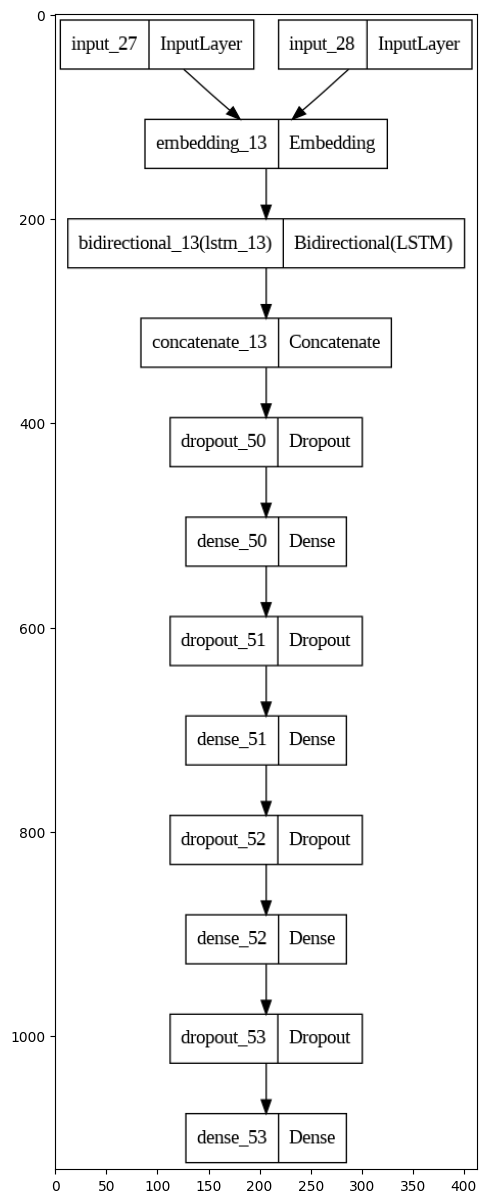

In [113]:
input_premises = Input(shape=(MAX_PREMISE_LENGTH,))
input_hypotheses = Input(shape=(MAX_HYPOTHESIS_LENGTH,))

embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE, weights=[embedding_matrix], trainable=False)
premises = embedding_layer(input_premises)
hypotheses = embedding_layer(input_hypotheses)

lstm_layer = Bidirectional(LSTM(512, return_sequences=False, dropout=DROPOUT))
premises = lstm_layer(premises)
hypotheses = lstm_layer(hypotheses)

merged = concatenate([premises, hypotheses], axis=-1)

x = Dropout(DROPOUT)(merged)
x = Dense(1024, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(DROPOUT)(x)
x = Dense(100, activation="relu")(x)
x = Dropout(DROPOUT)(x)
output_layer = Dense(NUM_LABELS, activation=OUTPUT_ACTIVATION)(x)

model = Model(inputs=[input_premises, input_hypotheses], outputs=output_layer)
model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=['accuracy'])

show_model_architecture(model=model, filename=f"{model_name}_architecture.png")

## Model Training

In [114]:
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.00001, min_delta=0.01)

In [115]:
history = model.fit([train_premises, train_hypotheses], train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT, callbacks=[callback])

Epoch 1/20
85/85 [==============================] - 26s 201ms/step - loss: 0.6917 - accuracy: 0.5588 - val_loss: 0.6229 - val_accuracy: 0.6536 - lr: 0.0010
Epoch 2/20
85/85 [==============================] - 16s 185ms/step - loss: 0.6261 - accuracy: 0.6536 - val_loss: 0.6008 - val_accuracy: 0.6604 - lr: 0.0010
Epoch 3/20
85/85 [==============================] - 15s 182ms/step - loss: 0.5950 - accuracy: 0.6774 - val_loss: 0.6152 - val_accuracy: 0.6485 - lr: 0.0010
Epoch 4/20
85/85 [==============================] - 16s 185ms/step - loss: 0.5755 - accuracy: 0.6915 - val_loss: 0.6022 - val_accuracy: 0.6920 - lr: 0.0010
Epoch 5/20
85/85 [==============================] - 16s 185ms/step - loss: 0.5432 - accuracy: 0.7169 - val_loss: 0.5779 - val_accuracy: 0.6864 - lr: 5.0000e-04
Epoch 6/20
85/85 [==============================] - 16s 185ms/step - loss: 0.5216 - accuracy: 0.7306 - val_loss: 0.5592 - val_accuracy: 0.6966 - lr: 5.0000e-04
Epoch 7/20
85/85 [==============================] - 16s 

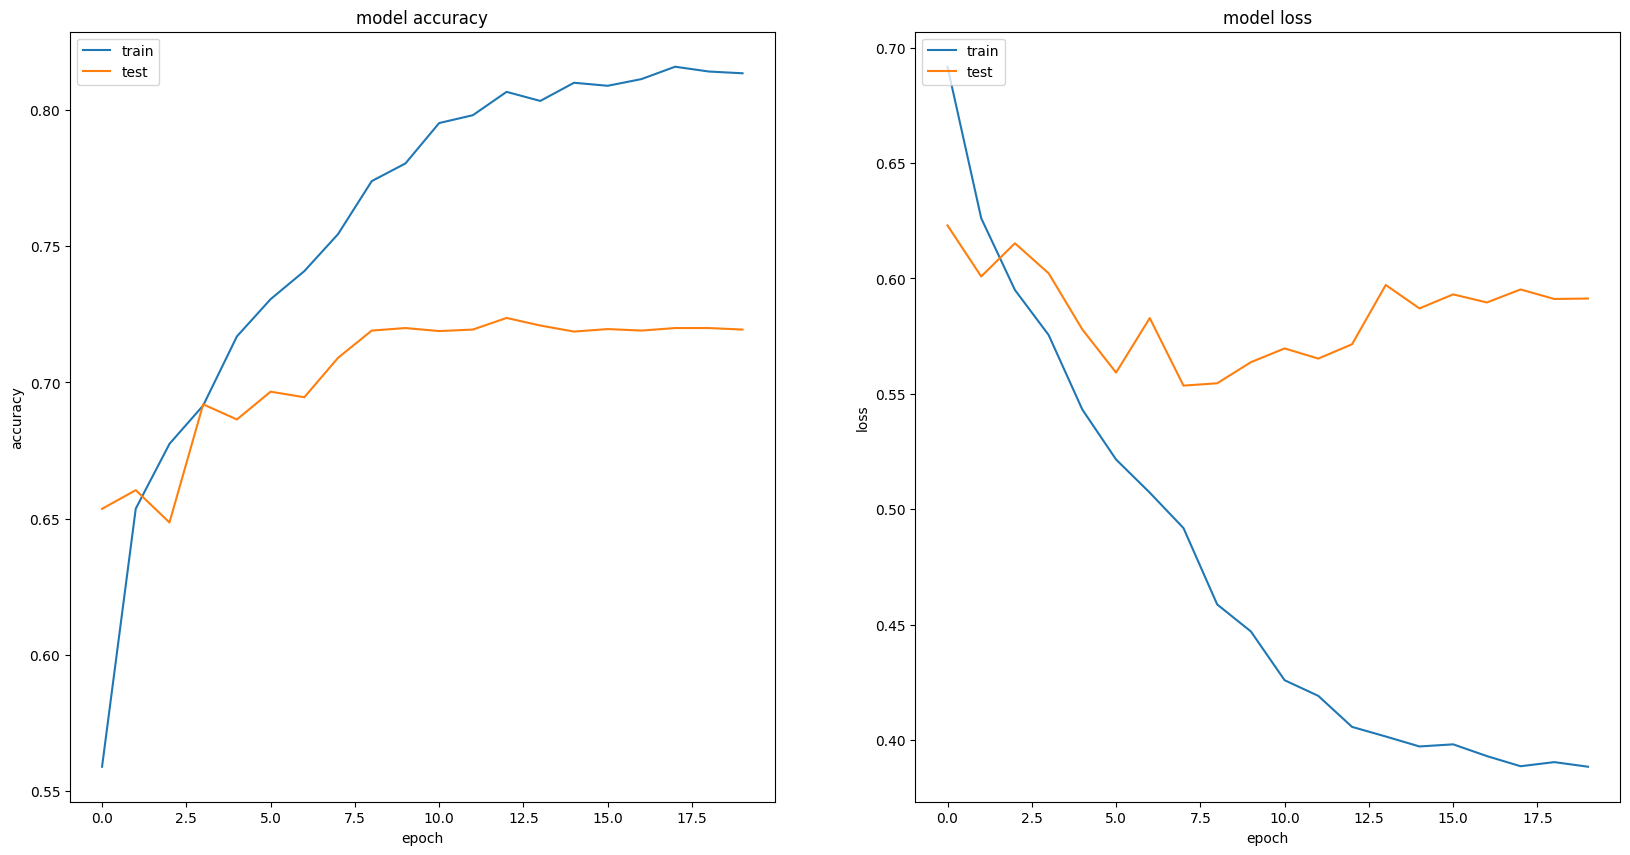

In [116]:
plot_history(history=history, export_path=f"{model_name}_architecture.pdf")

In [117]:
#Save the model
save_keras_model(model=model, filename="model_bert_embed")

## Model Evaluation

In [119]:
predicted_logits = model.predict(x=[dev_premises, dev_hypotheses])

#Evaluation Metrics
test_metrics = evaluate(true_labels=np.argmax(dev_labels, axis=1), predicted_logits=np.array(predicted_logits))
test_metrics.to_csv(os.path.join(results_dir, f"{model_name}_metrics.csv"), index=False)
test_metrics.head()

211/211 [==============================] - 3s 16ms/step


,Accuracy,Precision,Macro Precision,Weighted Macro Precision,Recall,Macro Recall,Weighted Macro Recall,F1-Score,Macro F1-Score,Weighted Macro F1-Score,MCC,Loss
0,0.723319,0.717638,0.723956,0.72375,0.765095,0.721915,0.723319,0.740607,0.722085,0.722687,0.445866,0.587196


# Experiment: Subtraction Sentence Fusion
Inspired by this paper & sentence fusion:
- https://ieeexplore.ieee.org/abstract/document/8029126

There appears to be 3 main ways to fuse sentences:
- Element-wise **subtraction**
- Element-wise **Multiplication**
- The two above but with **reversed** second sentences

Sentence fusion is where the two input sentences, of premises and hypotheses, are combined in different ways. Subtraction will subtract the hidden representations of either sequence. These representations are then passed through a further dense layer before the classifier layer. The 'fusion' layer refers to the dense layer afterwards.

This architecture experiments with just **subtraction**.

In [ ]:
model_name = "model_subtraction_fusion"

## Model Architecture

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 110)]                0         []                            
                                                                                                  
 input_32 (InputLayer)       [(None, 60)]                 0         []                            
                                                                                                  
 embedding_15 (Embedding)    multiple                     3860352   ['input_31[0][0]',            
                                                          0          'input_32[0][0]']            
                                                                                                  
 bidirectional_15 (Bidirect  (None, 1024)                 5246976   ['embedding_15[0][0]', 

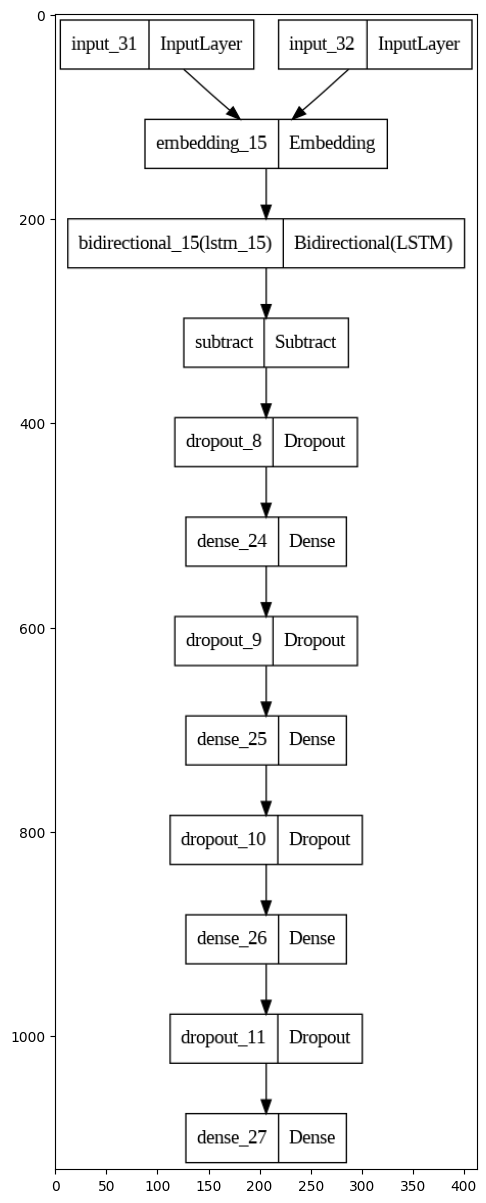

In [ ]:
input_premises = Input(shape=(MAX_PREMISE_LENGTH,))
input_hypotheses = Input(shape=(MAX_HYPOTHESIS_LENGTH,))

embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE, weights=[embedding_matrix], trainable=False)
premises = embedding_layer(input_premises)
hypotheses = embedding_layer(input_hypotheses)

lstm_layer = Bidirectional(LSTM(512, return_sequences=False, dropout=DROPOUT))
premises = lstm_layer(premises)
hypotheses = lstm_layer(hypotheses)

merged = subtract([premises, hypotheses])

x = Dropout(0.2)(merged)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.2)(x)
output_layer = Dense(NUM_LABELS, activation=OUTPUT_ACTIVATION)(x)

model = Model(inputs=[input_premises, input_hypotheses], outputs=output_layer)
model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=['accuracy'])

show_model_architecture(model=model, filename=f"{model_name}_architecture.png")

## Training

In [ ]:
history = model.fit([train_premises, train_hypotheses], train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

Epoch 1/10
85/85 [==============================] - 30s 198ms/step - loss: 0.6767 - accuracy: 0.5912 - val_loss: 0.6214 - val_accuracy: 0.6348
Epoch 2/10
85/85 [==============================] - 16s 185ms/step - loss: 0.6368 - accuracy: 0.6368 - val_loss: 0.6452 - val_accuracy: 0.6461
Epoch 3/10
85/85 [==============================] - 16s 186ms/step - loss: 0.6129 - accuracy: 0.6511 - val_loss: 0.6169 - val_accuracy: 0.6446
Epoch 4/10
85/85 [==============================] - 16s 185ms/step - loss: 0.5947 - accuracy: 0.6654 - val_loss: 0.6005 - val_accuracy: 0.6573
Epoch 5/10
85/85 [==============================] - 16s 189ms/step - loss: 0.5802 - accuracy: 0.6820 - val_loss: 0.5804 - val_accuracy: 0.6760
Epoch 6/10
85/85 [==============================] - 17s 195ms/step - loss: 0.5603 - accuracy: 0.6978 - val_loss: 0.6416 - val_accuracy: 0.6764
Epoch 7/10
85/85 [==============================] - 16s 185ms/step - loss: 0.6038 - accuracy: 0.6643 - val_loss: 0.6179 - val_accuracy: 0.6435

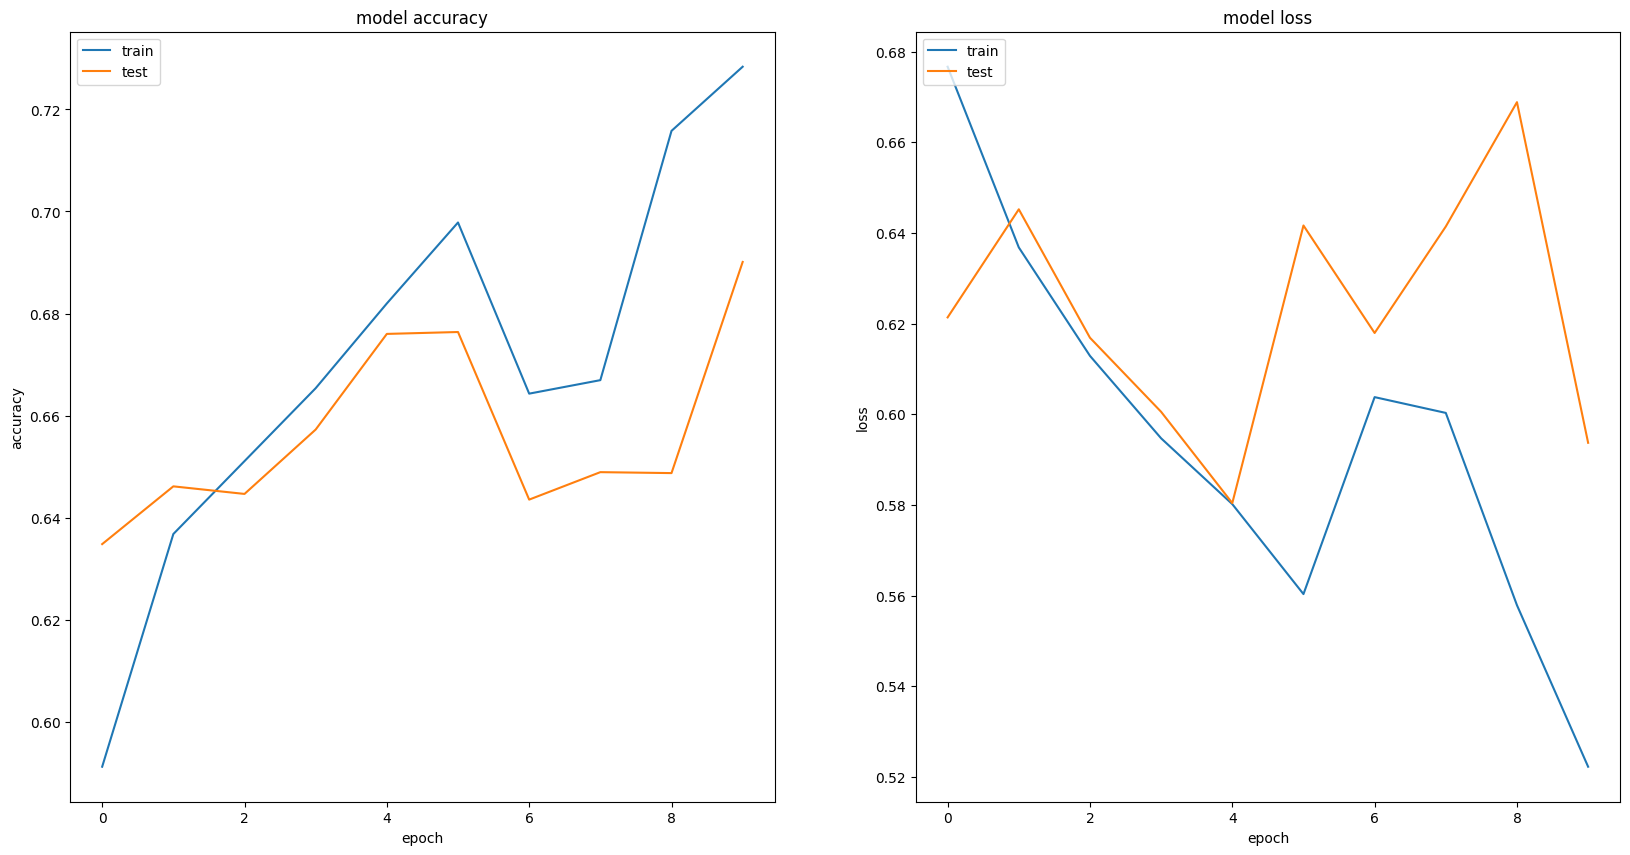

In [ ]:
#Plot model
plot_history(history=history, export_path=f"{model_name}_history.pdf")

In [ ]:
#Save the model
save_keras_model(model=model, filename=model_name)

## Evaluate

In [ ]:
predicted_logits = model.predict(x=[dev_premises, dev_hypotheses])

#Evaluation Metrics
test_metrics = evaluate(true_labels=np.argmax(dev_labels, axis=1), predicted_logits=np.array(predicted_logits))
test_metrics.to_csv(os.path.join(results_dir, f"{model_name}_metrics.csv"), index=False)
test_metrics.head()

211/211 [==============================] - 5s 22ms/step


,Accuracy,Precision,Macro Precision,Weighted Macro Precision,Recall,Macro Recall,Weighted Macro Recall,F1-Score,Macro F1-Score,Weighted Macro F1-Score,MCC,Loss
0,0.696007,0.671792,0.703469,0.702439,0.80391,0.692382,0.696007,0.731937,0.690446,0.691795,0.395695,0.584579


# Experiment: Multiplication Sentence Fusion


In [ ]:
model_name = "model_multiplication_fusion"

## Model Architecture

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_33 (InputLayer)       [(None, 110)]                0         []                            
                                                                                                  
 input_34 (InputLayer)       [(None, 60)]                 0         []                            
                                                                                                  
 embedding_16 (Embedding)    multiple                     3860352   ['input_33[0][0]',            
                                                          0          'input_34[0][0]']            
                                                                                                  
 bidirectional_16 (Bidirect  (None, 1024)                 5246976   ['embedding_16[0][0]', 

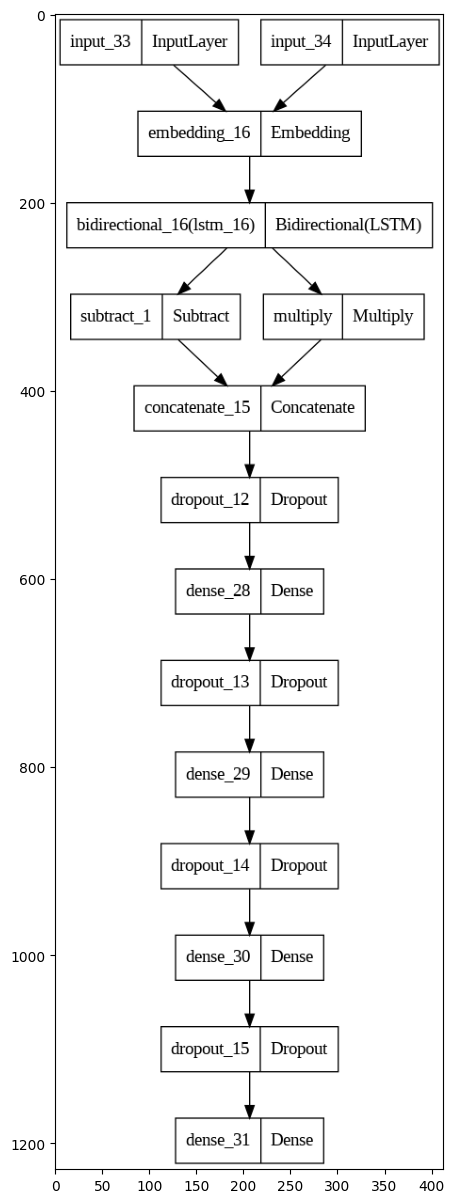

In [ ]:
input_premises = Input(shape=(MAX_PREMISE_LENGTH,))
input_hypotheses = Input(shape=(MAX_HYPOTHESIS_LENGTH,))

embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE, weights=[embedding_matrix], trainable=False)
premises = embedding_layer(input_premises)
hypotheses = embedding_layer(input_hypotheses)

lstm_layer = Bidirectional(LSTM(512, return_sequences=False, dropout=DROPOUT))
premises = lstm_layer(premises)
hypotheses = lstm_layer(hypotheses)

subtract_merge = subtract([premises, hypotheses])
multiply_merge = multiply([premises, hypotheses])
merged = concatenate([subtract_merge, multiply_merge])

x = Dropout(0.2)(merged)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.2)(x)
output_layer = Dense(NUM_LABELS, activation=OUTPUT_ACTIVATION)(x)

model = Model(inputs=[input_premises, input_hypotheses], outputs=output_layer)
model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=['accuracy'])

show_model_architecture(model=model, filename=f"{model_name}_architecture.png")

## Training

In [ ]:
history = model.fit([train_premises, train_hypotheses], train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

Epoch 1/10
85/85 [==============================] - 23s 205ms/step - loss: 0.6619 - accuracy: 0.6030 - val_loss: 0.6156 - val_accuracy: 0.6415
Epoch 2/10
85/85 [==============================] - 15s 182ms/step - loss: 0.6243 - accuracy: 0.6498 - val_loss: 0.6281 - val_accuracy: 0.6357
Epoch 3/10
85/85 [==============================] - 16s 185ms/step - loss: 0.5848 - accuracy: 0.6796 - val_loss: 0.6247 - val_accuracy: 0.6740
Epoch 4/10
85/85 [==============================] - 16s 183ms/step - loss: 0.5590 - accuracy: 0.7064 - val_loss: 0.5698 - val_accuracy: 0.6970
Epoch 5/10
85/85 [==============================] - 16s 187ms/step - loss: 0.5322 - accuracy: 0.7232 - val_loss: 0.5668 - val_accuracy: 0.7153
Epoch 6/10
85/85 [==============================] - 16s 191ms/step - loss: 0.5118 - accuracy: 0.7410 - val_loss: 0.6382 - val_accuracy: 0.6992
Epoch 7/10
85/85 [==============================] - 16s 188ms/step - loss: 0.4800 - accuracy: 0.7592 - val_loss: 0.5961 - val_accuracy: 0.7025

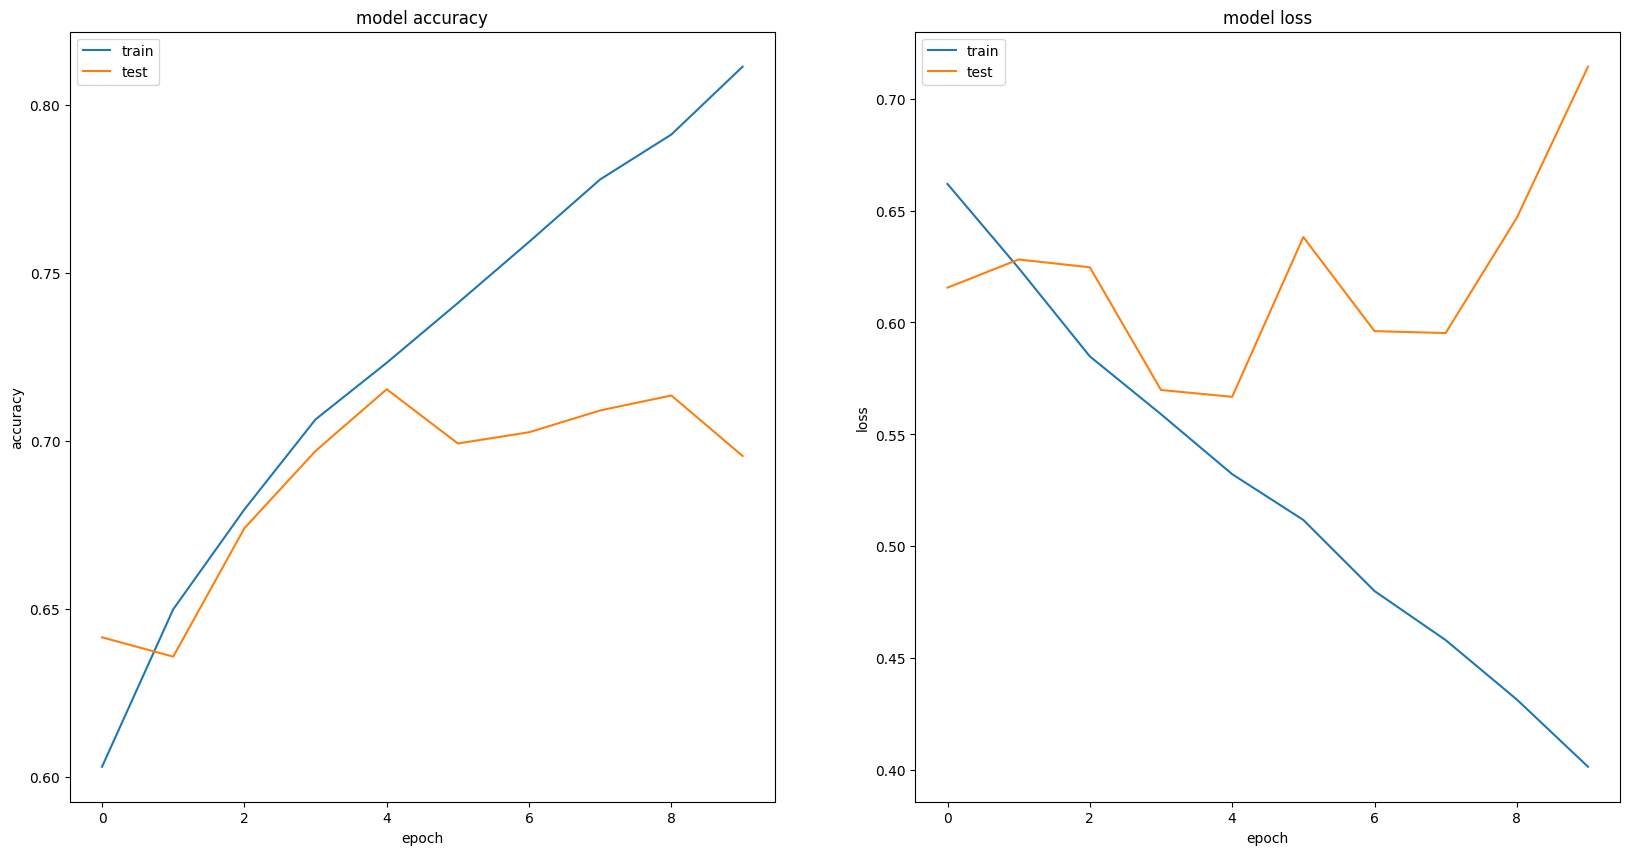

In [ ]:
#Plot model
plot_history(history=history, export_path=f"{model_name}_history.pdf")

In [ ]:
#Save the model
save_keras_model(model=model, filename=model_name)

## Evaluate

In [ ]:
predicted_logits = model.predict(x=[dev_premises, dev_hypotheses])

#Evaluation Metrics
test_metrics = evaluate(true_labels=np.argmax(dev_labels, axis=1), predicted_logits=np.array(predicted_logits))
test_metrics.to_csv(os.path.join(results_dir, f"{model_name}_metrics.csv"), index=False)
test_metrics.head()

211/211 [==============================] - 5s 15ms/step


,Accuracy,Precision,Macro Precision,Weighted Macro Precision,Recall,Macro Recall,Weighted Macro Recall,F1-Score,Macro F1-Score,Weighted Macro F1-Score,MCC,Loss
0,0.693484,0.782487,0.711711,0.714012,0.56268,0.697879,0.693484,0.654625,0.689554,0.688418,0.409356,0.693855


# Experiment: POS & NER Tags


In [142]:
model_name = "enhanced_embeddings"

## Model Architecture

In [152]:
POS_EMBEDDING_SIZE: int = 100
NER_EMBEDDING_SIZE: int = 50

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_41 (InputLayer)       [(None, 110)]                0         []                            
                                                                                                  
 input_43 (InputLayer)       [(None, 110)]                0         []                            
                                                                                                  
 input_45 (InputLayer)       [(None, 110)]                0         []                            
                                                                                                  
 input_42 (InputLayer)       [(None, 60)]                 0         []                            
                                                                                           

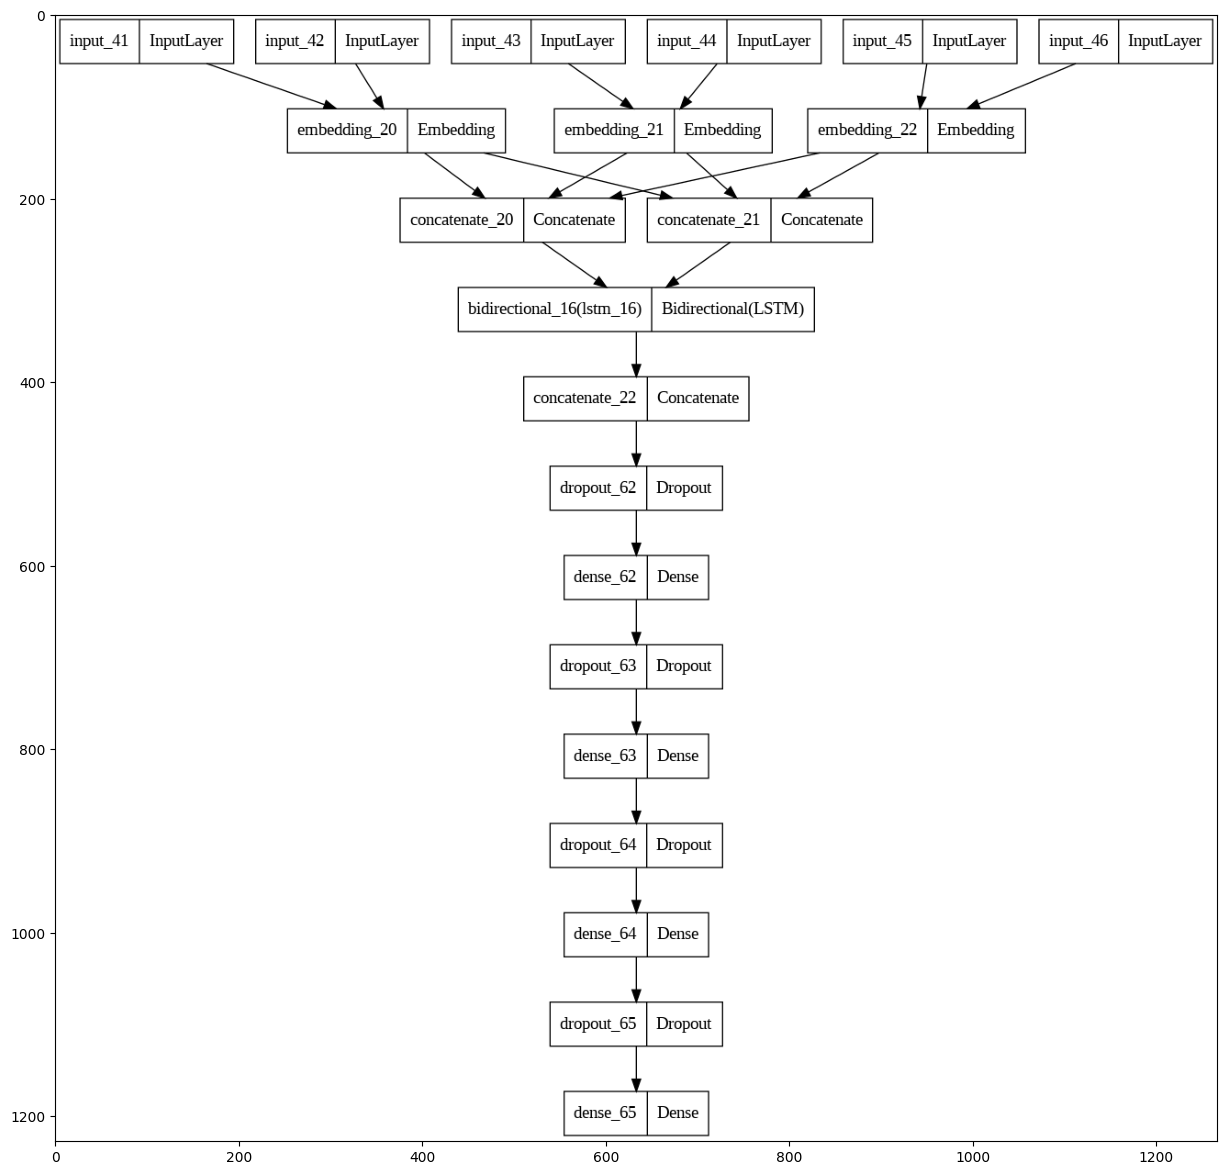

In [153]:
input_premises = Input(shape=(MAX_PREMISE_LENGTH,))
input_hypotheses = Input(shape=(MAX_HYPOTHESIS_LENGTH,))

input_premises_pos = Input(shape=(MAX_PREMISE_LENGTH,))
input_hypotheses_pos = Input(shape=(MAX_HYPOTHESIS_LENGTH,))

input_premises_ner = Input(shape=(MAX_PREMISE_LENGTH,))
input_hypotheses_ner = Input(shape=(MAX_HYPOTHESIS_LENGTH,))

embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE, weights=[embedding_matrix], trainable=False)
pos_embedding_layer = Embedding(input_dim=POS_VOCAB_SIZE, output_dim=POS_EMBEDDING_SIZE, trainable=True)
ner_embedding_layer = Embedding(input_dim=NER_VOCAB_SIZE, output_dim=NER_EMBEDDING_SIZE, trainable=True)

premises = embedding_layer(input_premises)
hypotheses = embedding_layer(input_hypotheses)

premises_pos = pos_embedding_layer(input_premises_pos)
hypotheses_pos = pos_embedding_layer(input_hypotheses_pos)

premises_ner = ner_embedding_layer(input_premises_ner)
hypotheses_ner = ner_embedding_layer(input_hypotheses_ner)

premise_concat = concatenate([premises, premises_pos, premises_ner], axis=-1)
hypothesis_concat = concatenate([hypotheses, hypotheses_pos, hypotheses_ner], axis=-1)

lstm_layer = Bidirectional(LSTM(512, return_sequences=False, dropout=DROPOUT))
premises = lstm_layer(premise_concat)
hypotheses = lstm_layer(hypothesis_concat)

merged = concatenate([premises, hypotheses], axis=-1)

x = Dropout(0.2)(merged)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.2)(x)
output_layer = Dense(NUM_LABELS, activation=OUTPUT_ACTIVATION)(x)

model = Model(inputs=[input_premises, input_premises_pos, input_premises_ner, input_hypotheses, input_hypotheses_pos, input_hypotheses_ner], outputs=output_layer)
model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=['accuracy'])

show_model_architecture(model=model, filename=f"{model_name}_architecture.png")

## Model Training

In [154]:
OPTIMIZER = RMSprop(INITIAL_LR)
EPOCHS = 100

In [155]:
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.00001, min_delta=0.01)

In [ ]:
history = model.fit([train_premises, train_premises_pos, train_premises_ner, train_hypotheses, train_hypotheses_pos, train_hypotheses_ner], train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT, callbacks = [callback])

Epoch 1/100
85/85 [==============================] - 26s 226ms/step - loss: 0.7124 - accuracy: 0.5473 - val_loss: 1.1722 - val_accuracy: 0.4825 - lr: 0.0010
Epoch 2/100
85/85 [==============================] - 18s 211ms/step - loss: 0.6299 - accuracy: 0.6482 - val_loss: 0.7208 - val_accuracy: 0.6203 - lr: 0.0010
Epoch 3/100
85/85 [==============================] - 18s 211ms/step - loss: 0.5950 - accuracy: 0.6779 - val_loss: 0.5739 - val_accuracy: 0.6883 - lr: 0.0010
Epoch 4/100
85/85 [==============================] - 18s 211ms/step - loss: 0.5715 - accuracy: 0.7003 - val_loss: 0.6257 - val_accuracy: 0.6532 - lr: 0.0010
Epoch 5/100
85/85 [==============================] - 18s 211ms/step - loss: 0.5512 - accuracy: 0.7120 - val_loss: 0.5659 - val_accuracy: 0.6981 - lr: 0.0010
Epoch 6/100
85/85 [==============================] - 18s 210ms/step - loss: 0.5086 - accuracy: 0.7436 - val_loss: 0.5455 - val_accuracy: 0.7152 - lr: 5.0000e-04
Epoch 7/100
85/85 [==============================] - 1

In [ ]:
plot_history(history=history, export_path=f"{model_name}_architecture.pdf")

In [ ]:
#Save the model
save_keras_model(model=model, filename=model_name)

## Model Evaluation

In [ ]:
predicted_logits = model.predict(x=[dev_premises, dev_premises_pos, dev_premises_ner, dev_hypotheses, dev_hypotheses_pos, dev_hypotheses_ner])

#Evaluation Metrics
test_metrics = evaluate(true_labels=np.argmax(dev_labels, axis=1), predicted_logits=np.array(predicted_logits))
test_metrics.to_csv(os.path.join(results_dir, f"{model_name}_metrics.csv"), index=False)
test_metrics.head()